In [114]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb
import scipy.stats as stats
import time
import matplotlib.dates as mdates

sns.set(style="whitegrid")

In [5]:
print(duckdb.__version__)

0.5.1


## Information

We want to investigate calendar and price of airbnbs. EDA on calendar and price. 

### Data

In [7]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

The variables from the calendar table are:

    * listing_id
    * date
    * available
    * price
    * adjusted_price
    * minimum_nights
    * maximum_nights

In [10]:
calendar_listings = con.execute('SELECT * from calendar').df()
calendar_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245531 entries, 0 to 10245530
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 547.2+ MB


The calendar table has 10 million rows. This is likely because we have an entry for each date a property is available on airbnb.

In [11]:
calendar_listings.head()

listing_id       date available  price  adjusted_price  minimum_nights  \
0        3943 2021-12-15         t   70.0            70.0             2.0   
1        3943 2021-12-16         t   70.0            70.0             2.0   
2        3943 2021-12-17         f   70.0            70.0             2.0   
3        3943 2021-12-18         f   70.0            70.0             2.0   
4        3943 2021-12-19         t   70.0            70.0             2.0   

   maximum_nights  
0          1125.0  
1          1125.0  
2          1125.0  
3          1125.0  
4          1125.0

We have listing_id which is unique and for each data the the listing is available there is an entry for it in the database and a price. We want to see if there is any relationship between price. 

# EDA

## Single Variable EDA

We'll start our EDA by looking at each variable individually, starting with the target variable, *price*.

## Price

Prices are the main variable of interest and represent price per night charged for that listing in the database. We would expect for there to be a lot of smaller charges and a few very large charges. The data is probably skewed right since airbnb is meant to compete with hotels in an area and usually the prices per night are less than `$100` on the platform.


In [17]:
calendar_listings.price.describe().round()

count    10245520.0
mean          201.0
std           482.0
min             0.0
25%            85.0
50%           127.0
75%           201.0
max         60141.0
Name: price, dtype: float64

The price variable shows the mean is `$201` per night with a std of `$482`. It is very likely the data is skewed or being impacted by very large outliers. The min is 0.00, which is very strange, some people are renting out their spaces for free? The median is `$127` and the 3rd-quartile is `$201`. The max is `$60141`! that is really high, I wonder I many of those values are in the data. Let's plot a histogram of the data using 50 bins, because of the outliers we need to account for such a massive difference.

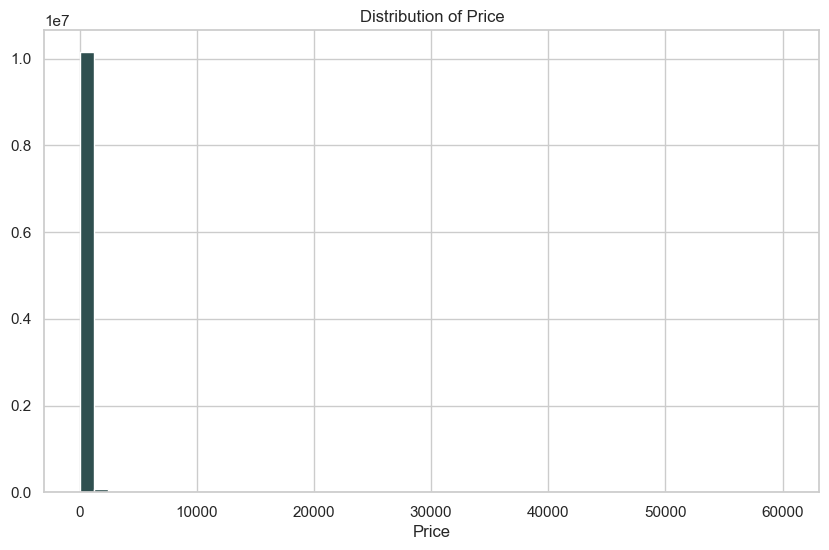

In [38]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(calendar_listings.price.round(), bins=50, color="darkslategray")
axes.set_title("Distribution of Price")
axes.set_xlabel("Price")

plt.show()
plt.close()

It looks like we need to set the range because all an vast majority of our values are below `$2000`. I'm going to check how many are above `$1000` and see if setting that as the max will help. 

In [40]:
print(calendar_listings[calendar_listings["price"] > 1000 ]["price"])

40729       2000.0
40730       2000.0
40731       2000.0
40732       2000.0
40733       2000.0
             ...  
10240770    1099.0
10240771    1099.0
10240772    1099.0
10240773    1099.0
10240774    1099.0
Name: price, Length: 133845, dtype: float64


It looks like 133845 values are above 1000 dollars per night, so that ~1.3% of our total values out of 10 million. I think we can trim by that value without an impact to the data.

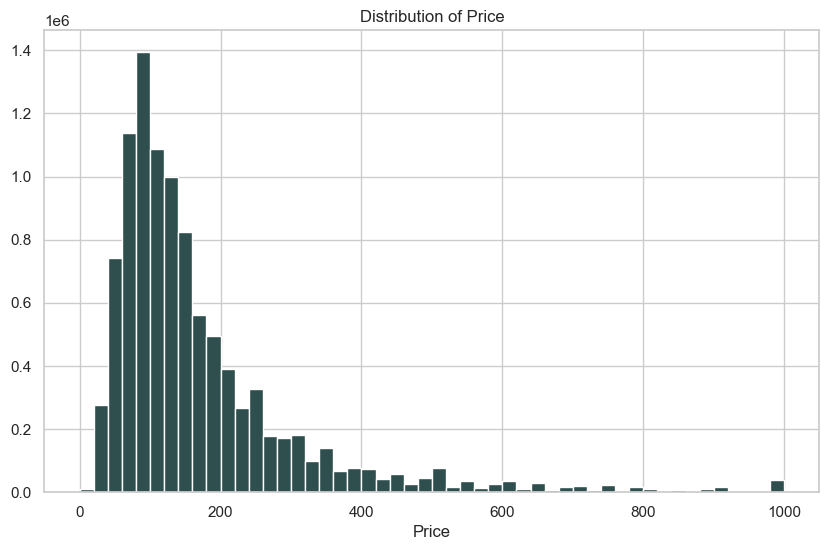

In [42]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(calendar_listings.price.round(),range=[0,1000], bins=50, color="darkslategray")
axes.set_title("Distribution of Price")
axes.set_xlabel("Price")

plt.show()
plt.close()

That's a better graph. We can see that most of the prices are between 100-300 per night.

## Date

The date is when the listing was available for booking. Each day it was available is a new row. I don't think we are going to see much other than a lot of listings being available 365 days a year. This date does not tell us if the airbnb was actually booked, it just lists that the host made it available.

In [44]:
calendar_listings.date.describe()

/var/folders/hd/mf02nvfn701271s23sy0bsv00000gn/T/ipykernel_78165/3999033874.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  calendar_listings.date.describe()


count                10245531
unique                    639
top       2022-10-30 00:00:00
freq                    28070
first     2021-12-15 00:00:00
last      2023-09-14 00:00:00
Name: date, dtype: object

There are 639 unique dates, which is kind of strange since there are only 365 days in a year. Otherwise we have the first date as 2021-12-15 and the last date as 2023-09-14. I guess we have some recent data in there so maybe it is more than four quarters.

In [45]:
calendar_listings.date.value_counts()

2022-10-30    28070
2022-10-18    28070
2022-10-09    28070
2022-10-10    28070
2022-10-11    28070
              ...  
2023-09-07     6471
2023-09-06     6471
2023-09-05     6471
2023-09-03     6471
2023-09-14     4147
Name: date, Length: 639, dtype: int64

Most of our data is in 2022 and some listings in 2023. Not all that helpful information because we know that most of our listings were going to be available on most dates.

## available

This is if the listing was available on a certain date.

In [47]:
calendar_listings.available.value_counts()

f        2891664
false    2876089
t        2350089
true     2127689
Name: available, dtype: int64

I think this is interesting, it looks like there are t, f, true, false. I think some cleaning is needed to change all the 't' to true and all the 'f' to false. 

In [48]:
calendar_listings.available.replace("t",'true', inplace=True)

In [49]:
calendar_listings.available.replace("f",'false', inplace=True)

Let's run the counts again.

In [50]:
calendar_listings.available.value_counts()

false    5767753
true     4477778
Name: available, dtype: int64

It looks like half of our listings were available and the other half were not available on a certain date. Let's just drop all the listings that were unavailable because we don't to know pricing data for when a listing could be rented not on dates it could not be rented. 

In [51]:
calendar_listings_clean = calendar_listings[calendar_listings.available != 'false'] 

In [53]:
calendar_listings_clean.available.value_counts()

true    4477778
Name: available, dtype: int64

Now we only have the listings where our airbnb was available. We'll use this clean listings going forward.

## adjusted_price

This is the adjusted price for a listing, I'm not exactly sure if this is different from price, from the data they appear to be identical. Let's use the same visualization method we did for price. 

In [56]:
calendar_listings.adjusted_price.describe().round()

count    10245520.0
mean          200.0
std           478.0
min             0.0
25%            85.0
50%           126.0
75%           200.0
max         60141.0
Name: adjusted_price, dtype: float64

It's actually identical to price. I think this might be redundant variable. I'm going to graph it to see if the shape of the data. 

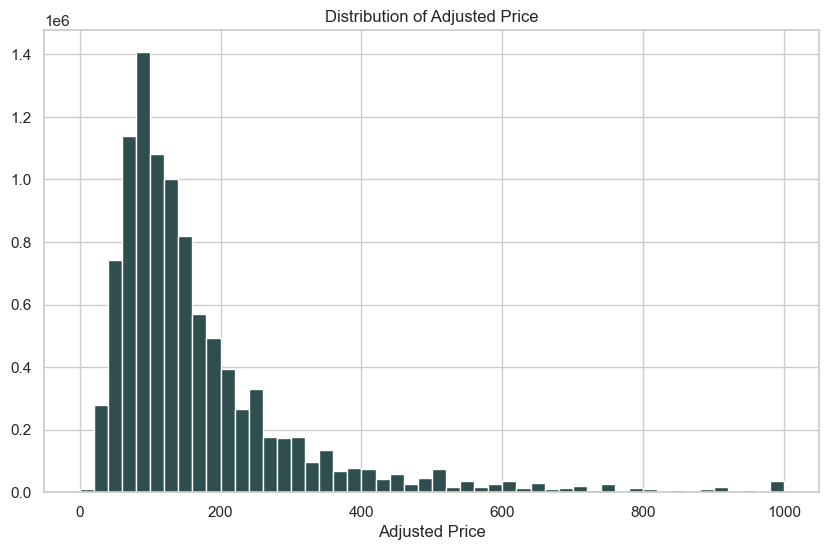

In [57]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(calendar_listings.adjusted_price.round(),range=[0,1000], bins=50, color="darkslategray")
axes.set_title("Distribution of Adjusted Price")
axes.set_xlabel("Adjusted Price")

plt.show()
plt.close()

Looks the same as our price graph.

## minimum nights

This is the number of minimum nights a listing has to be booked to confirm a booking with this host.

In [62]:
calendar_listings_clean.minimum_nights.describe().round()

count    4477176.0
mean          50.0
std          146.0
min            1.0
25%            2.0
50%            4.0
75%           31.0
max         1125.0
Name: minimum_nights, dtype: float64

This is interesting, the min number of nights is 1, the median is 4 nights, and the 3rd-quartile is 31, which means this is a short term rental or a month-month lease situation. The max number of minimum night is 1125! That's 3 years of rental! That does not conform to the airbnb service. The mean and std are not believable at 50 and 146, this is likely very skewed.

Let's plot a histogram of the data using a range because we know that most of our minimum nights is between 1-31, which 1125 as an outlier.  

To get the range we should use, I'm going to check how many listings have a min_night above 50. 

In [68]:
print(calendar_listings_clean[calendar_listings_clean["minimum_nights"] > 50 ]["minimum_nights"])

830          60.0
831          60.0
832          60.0
833          60.0
834          60.0
            ...  
10240231    120.0
10240232    120.0
10240233    120.0
10240234    120.0
10240235    120.0
Name: minimum_nights, Length: 582792, dtype: float64


That is 13% of our listings are above 50 days minimum, we need to pick a higher range. 

In [73]:
print(calendar_listings_clean[calendar_listings_clean["minimum_nights"] > 365 ]["minimum_nights"])

263265     600.0
263266     600.0
263267     600.0
263268     600.0
263269     600.0
           ...  
9929801    600.0
9929802    600.0
9929803    600.0
9929804    600.0
9929805    600.0
Name: minimum_nights, Length: 184058, dtype: float64


It looks like about 4% of our listings have a minimum nights requirement above 365 days. That's outside the range of our four querters so I'm going to use that as the cut-off. 

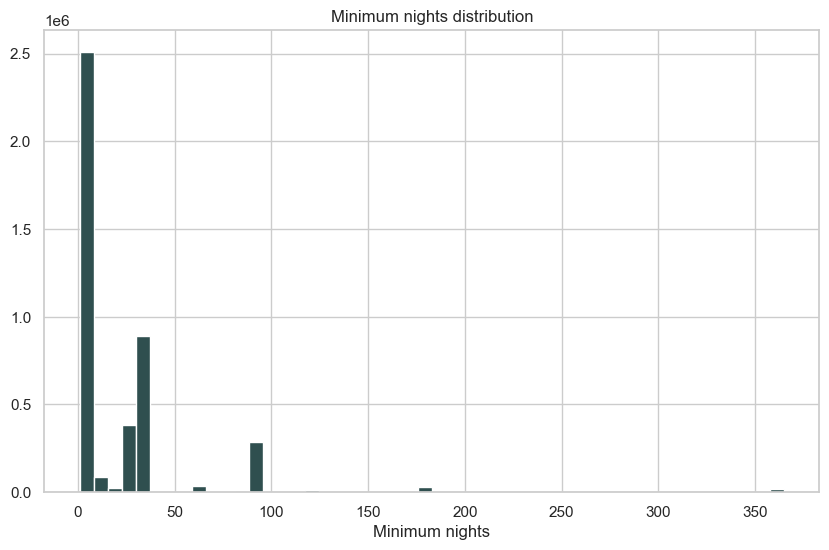

In [76]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(calendar_listings_clean.minimum_nights,range=[1,365], bins=50, color="darkslategray")
axes.set_title("Minimum nights distribution")
axes.set_xlabel("Minimum nights")

plt.show()
plt.close()

Let's look at a smaller range so we can get a better sense of the data.

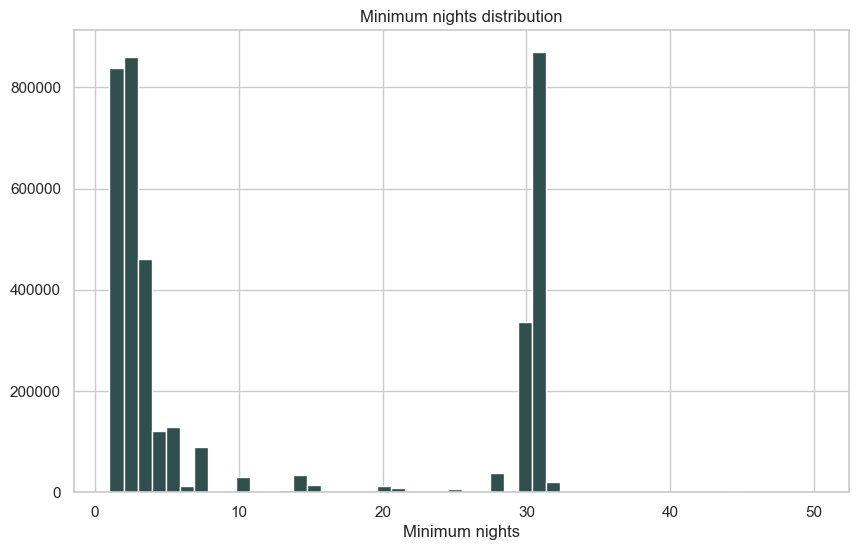

In [77]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(calendar_listings_clean.minimum_nights,range=[1,50], bins=50, color="darkslategray")
axes.set_title("Minimum nights distribution")
axes.set_xlabel("Minimum nights")

plt.show()
plt.close()

We can see from the above graph that most of our listings have a minimum night of 1-3 and there is also a very large group that is equal to the 1-2 night minimum that requires 31 nights, that is basically a month-to-month lease.

## Maximum Nights

The maximum nights variable is the max number of nights an airbnb can be rented to a single user in any consecutive number of days as set by the host. It's the opposite of the minimum, in that it is a limit not a requirement. 

In [100]:
calendar_listings_clean.maximum_nights.describe().round()

count    4.477176e+06
mean     1.535707e+07
std      1.809363e+08
min      1.000000e+00
25%      3.650000e+02
50%      1.125000e+03
75%      1.125000e+03
max      2.147484e+09
Name: maximum_nights, dtype: float64

In [101]:
calendar_listings_clean.maximum_nights.value_counts()

1125.0    2779234
365.0      809319
30.0        90254
90.0        74193
180.0       57057
           ...   
358.0          51
359.0          51
361.0          51
363.0          51
489.0           6
Name: maximum_nights, Length: 399, dtype: int64

This is very interesting in the way the majority of listings is set to maximum nights of 1125 nights, and another large portion is 365 nights, then 30 nights and so on. Let's visualize the data.

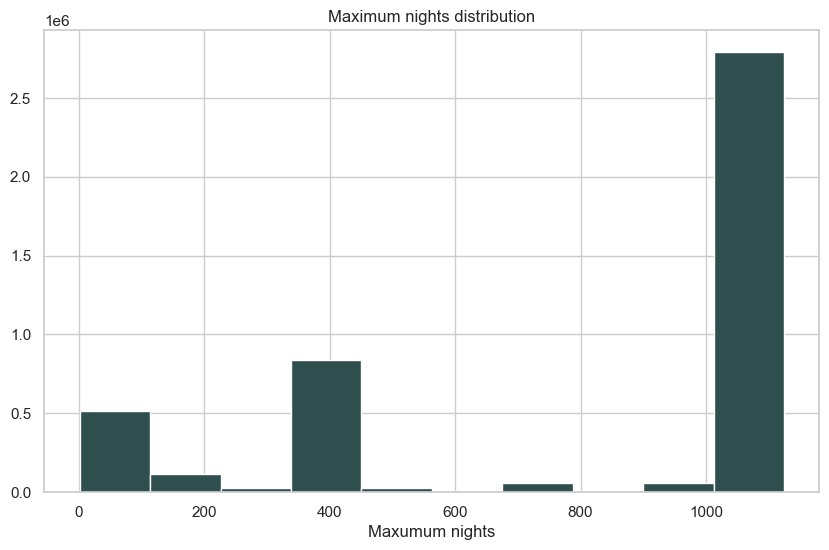

In [106]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(calendar_listings_clean.maximum_nights,range=[1,1125], bins=10, color="darkslategray")
axes.set_title("Maximum nights distribution")
axes.set_xlabel("Maxumum nights")

plt.show()
plt.close()

The majority of hosts choose to use a maximum nights of 1125, which is a little over 3 years. Strange, but I guess if it is a maximum then most people who are booking don't actually select that many nights. It could just be a default setting that the majority of hosts don't change. I'm not familiar with how hosts on airbnb can set these settings. The other theory is that a lot of these rentals are full-time airbnbs not actual homes. I don't think most people want a stranger to stay in their house for 3 years straight. I could be wrong about that. 

## Price v. Date

Date seems like it could impact price and it is the main data point of this table. I assume prices increase at certain times of the year and decrease at other times based on demand. Let's look first at the correlation coefficients even though it might not be linear or monotonic. Note I'm using the clean version of the data frame because we just want to know the price for when our bnb is available to actually rent.

In [112]:
calendar_listings_clean.date = calendar_listings_clean.date = pd.to_datetime(calendar_listings_clean.date)

/var/folders/hd/mf02nvfn701271s23sy0bsv00000gn/T/ipykernel_78165/485529046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendar_listings_clean.date = calendar_listings_clean.date = pd.to_datetime(calendar_listings_clean.date)


In [135]:
cal_listing_price_round = calendar_listings_clean.price.fillna(0)
cal_listing_price_round = cal_listing_price_round.astype(int)
print(cal_listing_price_round)

0            70
1            70
4            70
5            70
6            70
           ... 
10245161    110
10245162    110
10245163    110
10245164    139
10245165    139
Name: price, Length: 4477778, dtype: int64


In [137]:
print("r   = ", stats.pearsonr(cal_listing_price_round, mdates.date2num(calendar_listings_clean.date))[0])
print("rho = ", stats.spearmanr(cal_listing_price_round, mdates.date2num(calendar_listings_clean.date))[0])

r   =  0.006077848101354423
rho =  0.01905936155012978


Pearson's correlation coefficient, $r$, is only 0.0061 which indicates an extremely weak positive relationship. Spearman's is more interesting at 0.019 which might indicate that at least a weak monotonic relationship. Let's plot the data:

In [146]:
figure = plt.figure(figsize=(100, 100))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( calendar_listings_clean.date, cal_listing_price_round, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Date")
axes.set_title("Scatter Plot of Price vs. Date")

plt.show()
plt.close()

It looks like there are distinct bands for a price and they stay consistent without increasing or decreasing. It might be worth flipping this graph and limiting the price to a range of 0-1000 dollars. 

In [145]:
figure = plt.figure(figsize=(100, 100))

axes = figure.add_subplot(2, 1, 1)
axes.hist(cal_listing_price_round,range=[0,1000], bins=50,color="darkslategray")
axes.set_title("Price distribution")
axes.set_xlabel("Price")

axes = figure.add_subplot(2, 1, 2)
axes.scatter( cal_listing_price_round, calendar_listings_clean.date, marker="o", color="darkslategray")

axes.set_ylabel("Date")
axes.set_xlabel("Price")
axes.set_title("Scatter Plot of Price vs. Date")

plt.xlim([0, 1000])
plt.show()
plt.close()

If we really zoom out on the data, we can see that at the lower price ranges, the date does not change the price at all. I think one reason for that is because the owners of airbnb are not business savvy, they don't have surge pricing like uber. A host renting out on airbnb sets a price they are comfortable with in terms of costs and the amount of profit they want to make and they set that price. Most hosts are not looking at which times of the year have a higher demand to set prices to capture demand. They keep prices uniform, as a set it and forget it strategy.  

In some of the higher bands, we can see that there are certain times of the year were the pricing does shift a little bit, higher or lower depending on the time of year. That could be due to seasonality, or some other factor not accounted for in our data.

## Price v Available

This variable is true or false so I don't think we will see much of a correlation with price.

In [149]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe().round()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [150]:
describe_by_category(calendar_listings, "price", "available", transpose=True)

available      false       true
count      5767753.0  4477767.0
mean           200.0      202.0
std            393.0      577.0
min              0.0       10.0
25%             85.0       88.0
50%            125.0      133.0
75%            200.0      212.0
max          24999.0    60141.0


This is interesting, the fist thing we see is that when a property is not available for rent it can have a minimum price of `$0`, but when it is available the minimum price is `$10`. I think the other summary statistics are based on that difference, which leads to a skewed result for mean between the false and true category. The max value is also different between the categories but that is meaningless because if the bnb is not available to rent, then it can have any price. 

## Price v. Minimum Nights

The minimum night might be a good variable comparison to price because if the minimum night is low, we might assume a slightly higher price compared to one where the minimum nights is high, since the cost overall for a guest is higher for those bookings.

Remove any null/nan values

In [153]:
cal_listing_min_night_clean = calendar_listings_clean.minimum_nights.fillna(0)

In [154]:
print("r   = ", stats.pearsonr(cal_listing_price_round, cal_listing_min_night_clean)[0])
print("rho = ", stats.spearmanr(cal_listing_price_round, cal_listing_min_night_clean)[0])

r   =  -0.013557885142486552
rho =  -0.07099643599974306


Pearson's correlation coefficient, $r$, is only -0.014 which indicates a weak inverse relationship. Spearman's is more interesting at -0.07 which might indicate that at least a weak inverse monotonic relationship. I think our assumption was partly correct because the inverse relationship means that as minimum nights goes up, prices goes down. Let's plot the data:

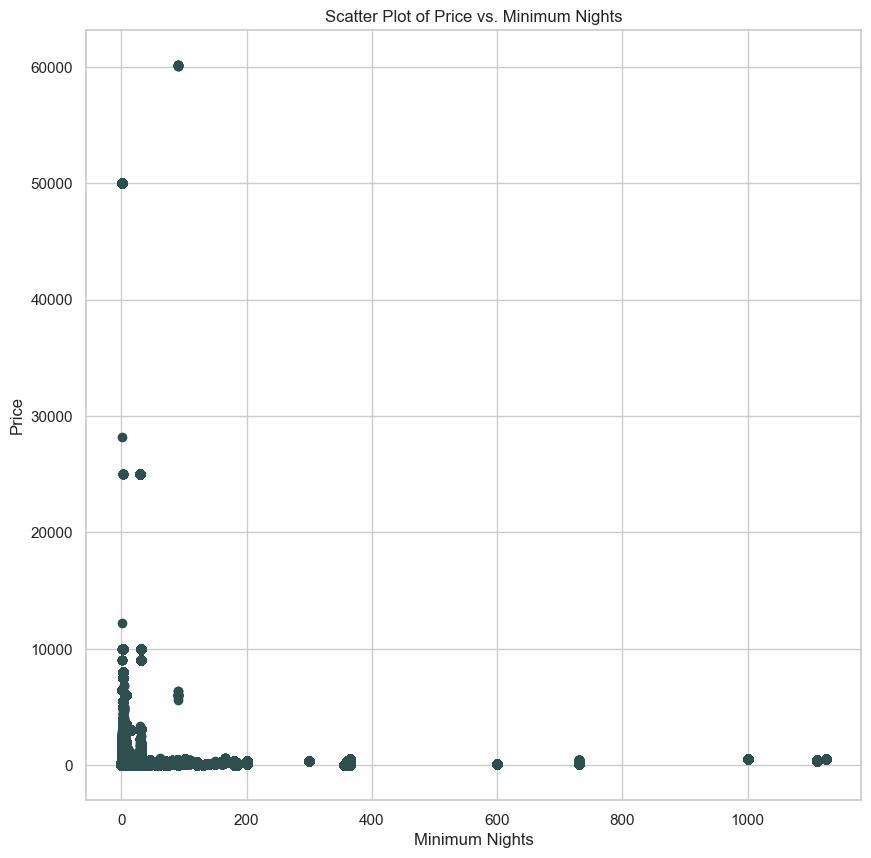

In [156]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(cal_listing_min_night_clean, cal_listing_price_round, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Minimum Nights")
axes.set_title("Scatter Plot of Price vs. Minimum Nights")

plt.show()
plt.close()

Let's plot this with a limit of 365 days. 

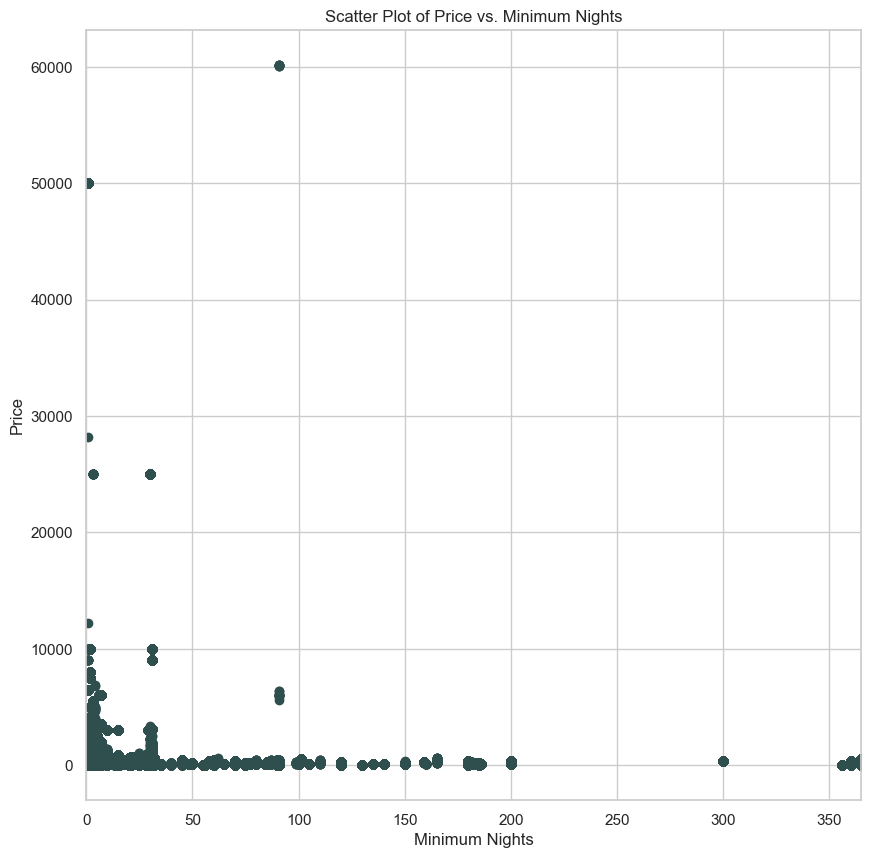

In [157]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(cal_listing_min_night_clean, cal_listing_price_round, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Minimum Nights")
axes.set_title("Scatter Plot of Price vs. Minimum Nights")

plt.xlim([0, 365])
plt.show()
plt.close()

Let's plot if from the other direction. 

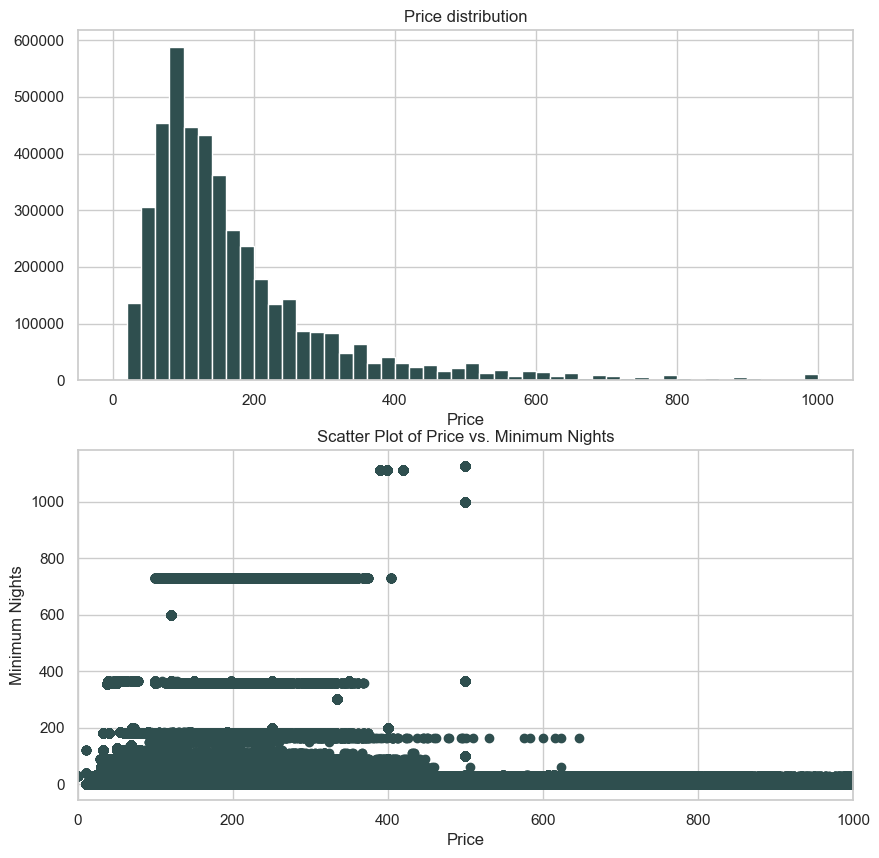

In [159]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(2, 1, 1)
axes.hist(cal_listing_price_round,range=[0,1000], bins=50,color="darkslategray")
axes.set_title("Price distribution")
axes.set_xlabel("Price")

axes = figure.add_subplot(2, 1, 2)
axes.scatter( cal_listing_price_round, cal_listing_min_night_clean, marker="o", color="darkslategray")

axes.set_ylabel("Minimum Nights")
axes.set_xlabel("Price")
axes.set_title("Scatter Plot of Price vs. Minimum Nights")

plt.xlim([0, 1000])
plt.show()
plt.close()

We can see from the above scatter plot that there is a wide range of prices with 0 minimum nights but as we get higher in the minimum nights required, the price does start to have a lower maximum price number, especially as we get to the higher minimum nights. 

Let's look at a slice of this data where the minimum nights is set to 0-31 and price is 0-1000 that should cover 90% of our data.

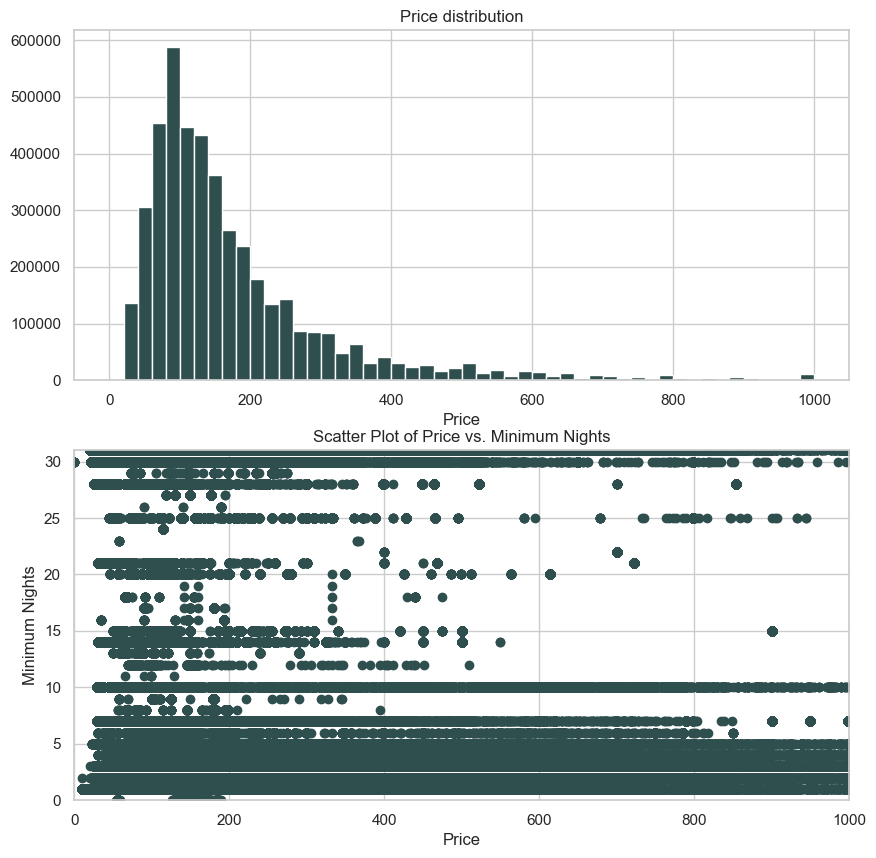

In [162]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(2, 1, 1)
axes.hist(cal_listing_price_round,range=[0,1000], bins=50,color="darkslategray")
axes.set_title("Price distribution")
axes.set_xlabel("Price")

axes = figure.add_subplot(2, 1, 2)
axes.scatter( cal_listing_price_round, cal_listing_min_night_clean, marker="o", color="darkslategray")

axes.set_ylabel("Minimum Nights")
axes.set_xlabel("Price")
axes.set_title("Scatter Plot of Price vs. Minimum Nights")

plt.xlim([0, 1000])
plt.ylim([0, 31])
plt.show()
plt.close()

We can see that there are specific bands at 0-5, and 10 nights. At seven night minimum the prices are lower and as we go up, the prices listed are most scattered. At 31 night minimum we see the prices start to look like the 0 night minimum. I find that very odd because that is almost like a month-to-month lease. However, it does look like those airbnbs are just priced for continuous stay. They are not competing with single night pricing because most hosts don't actually offer 31 days of straight bookings even if they have availability. The 31 night minimum listings can charge any price because they are filling a niche in the market for bnbs.  

## Price v. Maximum Nights

The maximum nights is the max number of nights a person can book a bnb. We saw from our EDA that a majority of our listings have it set at 1125 which is over 3 years! I think this might be the default setting and many don't bother changing it. I suspect we might see some correlation but since this is a maximum, I don't think it will capture the nuances of the data and how people actually book airbnb stays for short terms. 

In [164]:
cal_listing_max_night_clean = calendar_listings_clean.maximum_nights.fillna(0)

In [165]:
print("r   = ", stats.pearsonr(cal_listing_price_round, cal_listing_max_night_clean)[0])
print("rho = ", stats.spearmanr(cal_listing_price_round, cal_listing_max_night_clean)[0])

r   =  0.021802403289781915
rho =  0.1254607606639578


Pearson's correlation coefficient, $r$, is only 0.022 which indicates a weak positive relationship. Spearman's is more interesting at 0.12 which might indicate a weak monotonic relationship. That is actually the highest we have gotten from our EDA so far. Let's plot the data:

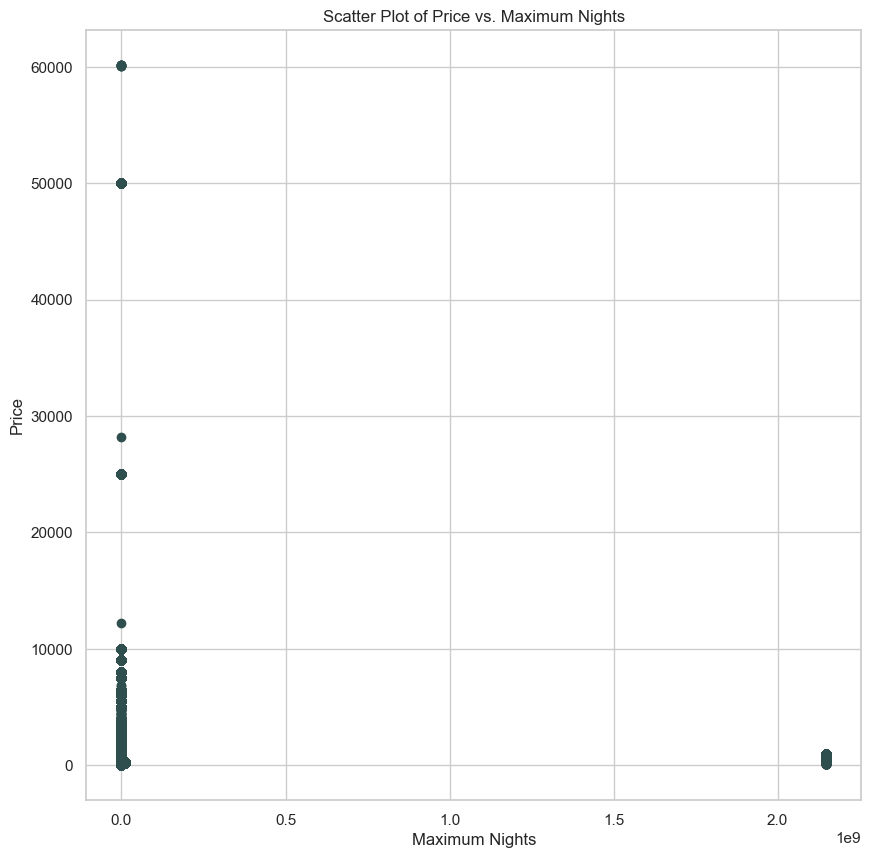

In [166]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(cal_listing_max_night_clean, cal_listing_price_round, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Maximum Nights")
axes.set_title("Scatter Plot of Price vs. Maximum Nights")

plt.show()
plt.close()

Let's replot this with some better bounds such as price limited to $0-1000 and maximum nights 0-365

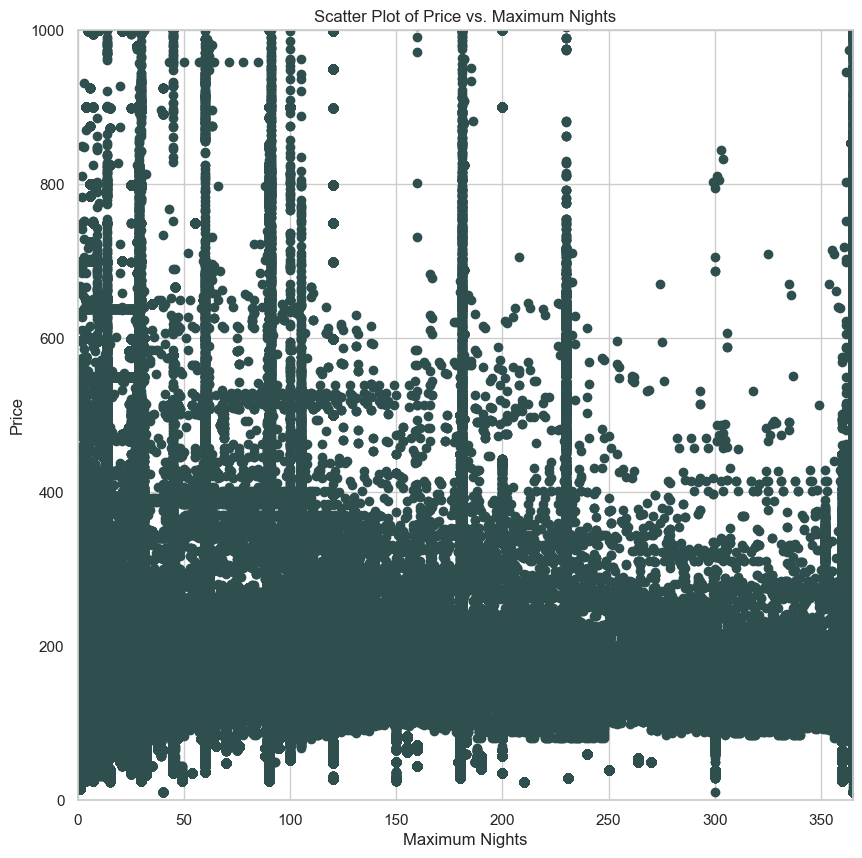

In [167]:
figure = plt.figure(figsize=(20, 20))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(cal_listing_max_night_clean, cal_listing_price_round, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Maximum Nights")
axes.set_title("Scatter Plot of Price vs. Maximum Nights")

plt.xlim([0, 365])
plt.ylim([0, 1000])
plt.show()
plt.close()

We get a better sense of the bands in pricing vs. maximum nights. I'm not certain how useful this data is because it does not have a clear pattern. It's difficult to work with maximums because not of the behavior is not going to be captured in this variable. If we could learn what the average number of nights someone was booking a listing, that would be more helpful than a maximum. I think a host is more likely to adjust their price if they are seeing low average booking compared to availability over the maximum nights setting which is likely a default that most hosts just leave as is.